# Forecasting Konsumsi Listrik – Instruksi EAS PAP
Notebook ini mengikuti instruksi EAS PAP:
1. **Model A:** XGBoost  
2. **Model B:** LSTM Multivariat  
3. **Ensemble:** Rata-rata prediksi XGBoost + GRU

**Skenario Eksperimen:** 80/20, 70/30, 60/40 pembagian data  
**Evaluasi:** RMSE  
**Forecast:** 2160 jam ke depan menggunakan model Ensemble

In [ ]:
# 1. Import Library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_squared_error
from xgboost import XGBRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, GRU, Input
from tensorflow.keras.callbacks import EarlyStopping
from keras.models import Sequential
from statsmodels.tsa.seasonal import seasonal_decompose

plt.rcParams['figure.figsize'] = (12,6)

In [41]:
# 2. Load Data
df_train = pd.read_csv('data_train.csv', parse_dates=['tanggal_waktu'], index_col='tanggal_waktu')
df_test = pd.read_csv('data_test.csv', parse_dates=['tanggal_waktu'], index_col='tanggal_waktu')
print('Train:', df_train.shape, 'Test:', df_test.shape)

Train: (24336, 7) Test: (2160, 6)


In [42]:
# 3. Pra-pemrosesan Umum
df = df_train.copy()
# Ganti 99999 -> NaN & interpolasi
df['konsumsi_listrik'].replace(99999, np.nan, inplace=True)

# Outlier Handling (IQR method)
Q1 = df['konsumsi_listrik'].quantile(0.25)
Q3 = df['konsumsi_listrik'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Tandai outlier dan missing value sebagai NaN
df.loc[(df['konsumsi_listrik'] < lower_bound) | (df['konsumsi_listrik'] > upper_bound), 'konsumsi_listrik'] = np.nan
df.replace(['', ' ', 'null', 'NaN'], np.nan, inplace=True)

# Interpolasi nilai yang hilang (99999 atau outlier)
df['konsumsi_listrik'] = df['konsumsi_listrik'].interpolate()

# Label Encoding
df['dampak_env_enc'] = LabelEncoder().fit_transform(df['dampak_lingkungan'])
df_test['dampak_env_enc'] = LabelEncoder().fit_transform(df_test['dampak_lingkungan'])

# Fitur waktu
for d in [df, df_test]:
    d['hour'] = d.index.hour
    d['dayofweek'] = d.index.dayofweek

# Fungsi lag features
def make_lags(data, lags=[1,24]):
    df_ = data.copy()
    for lag in lags:
        df_[f'lag{lag}'] = df_['konsumsi_listrik'].shift(lag)
    return df_

df = make_lags(df)
df.dropna(inplace=True)
features = ['suhu','beban_listrik','kecepatan_angin','tekanan_udara',
            'dampak_env_enc','hour','dayofweek','lag1','lag24']

C:\Users\hp\AppData\Local\Temp\ipykernel_3400\3204763458.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['konsumsi_listrik'].replace(99999, np.nan, inplace=True)


### Exploratory Data Analysis

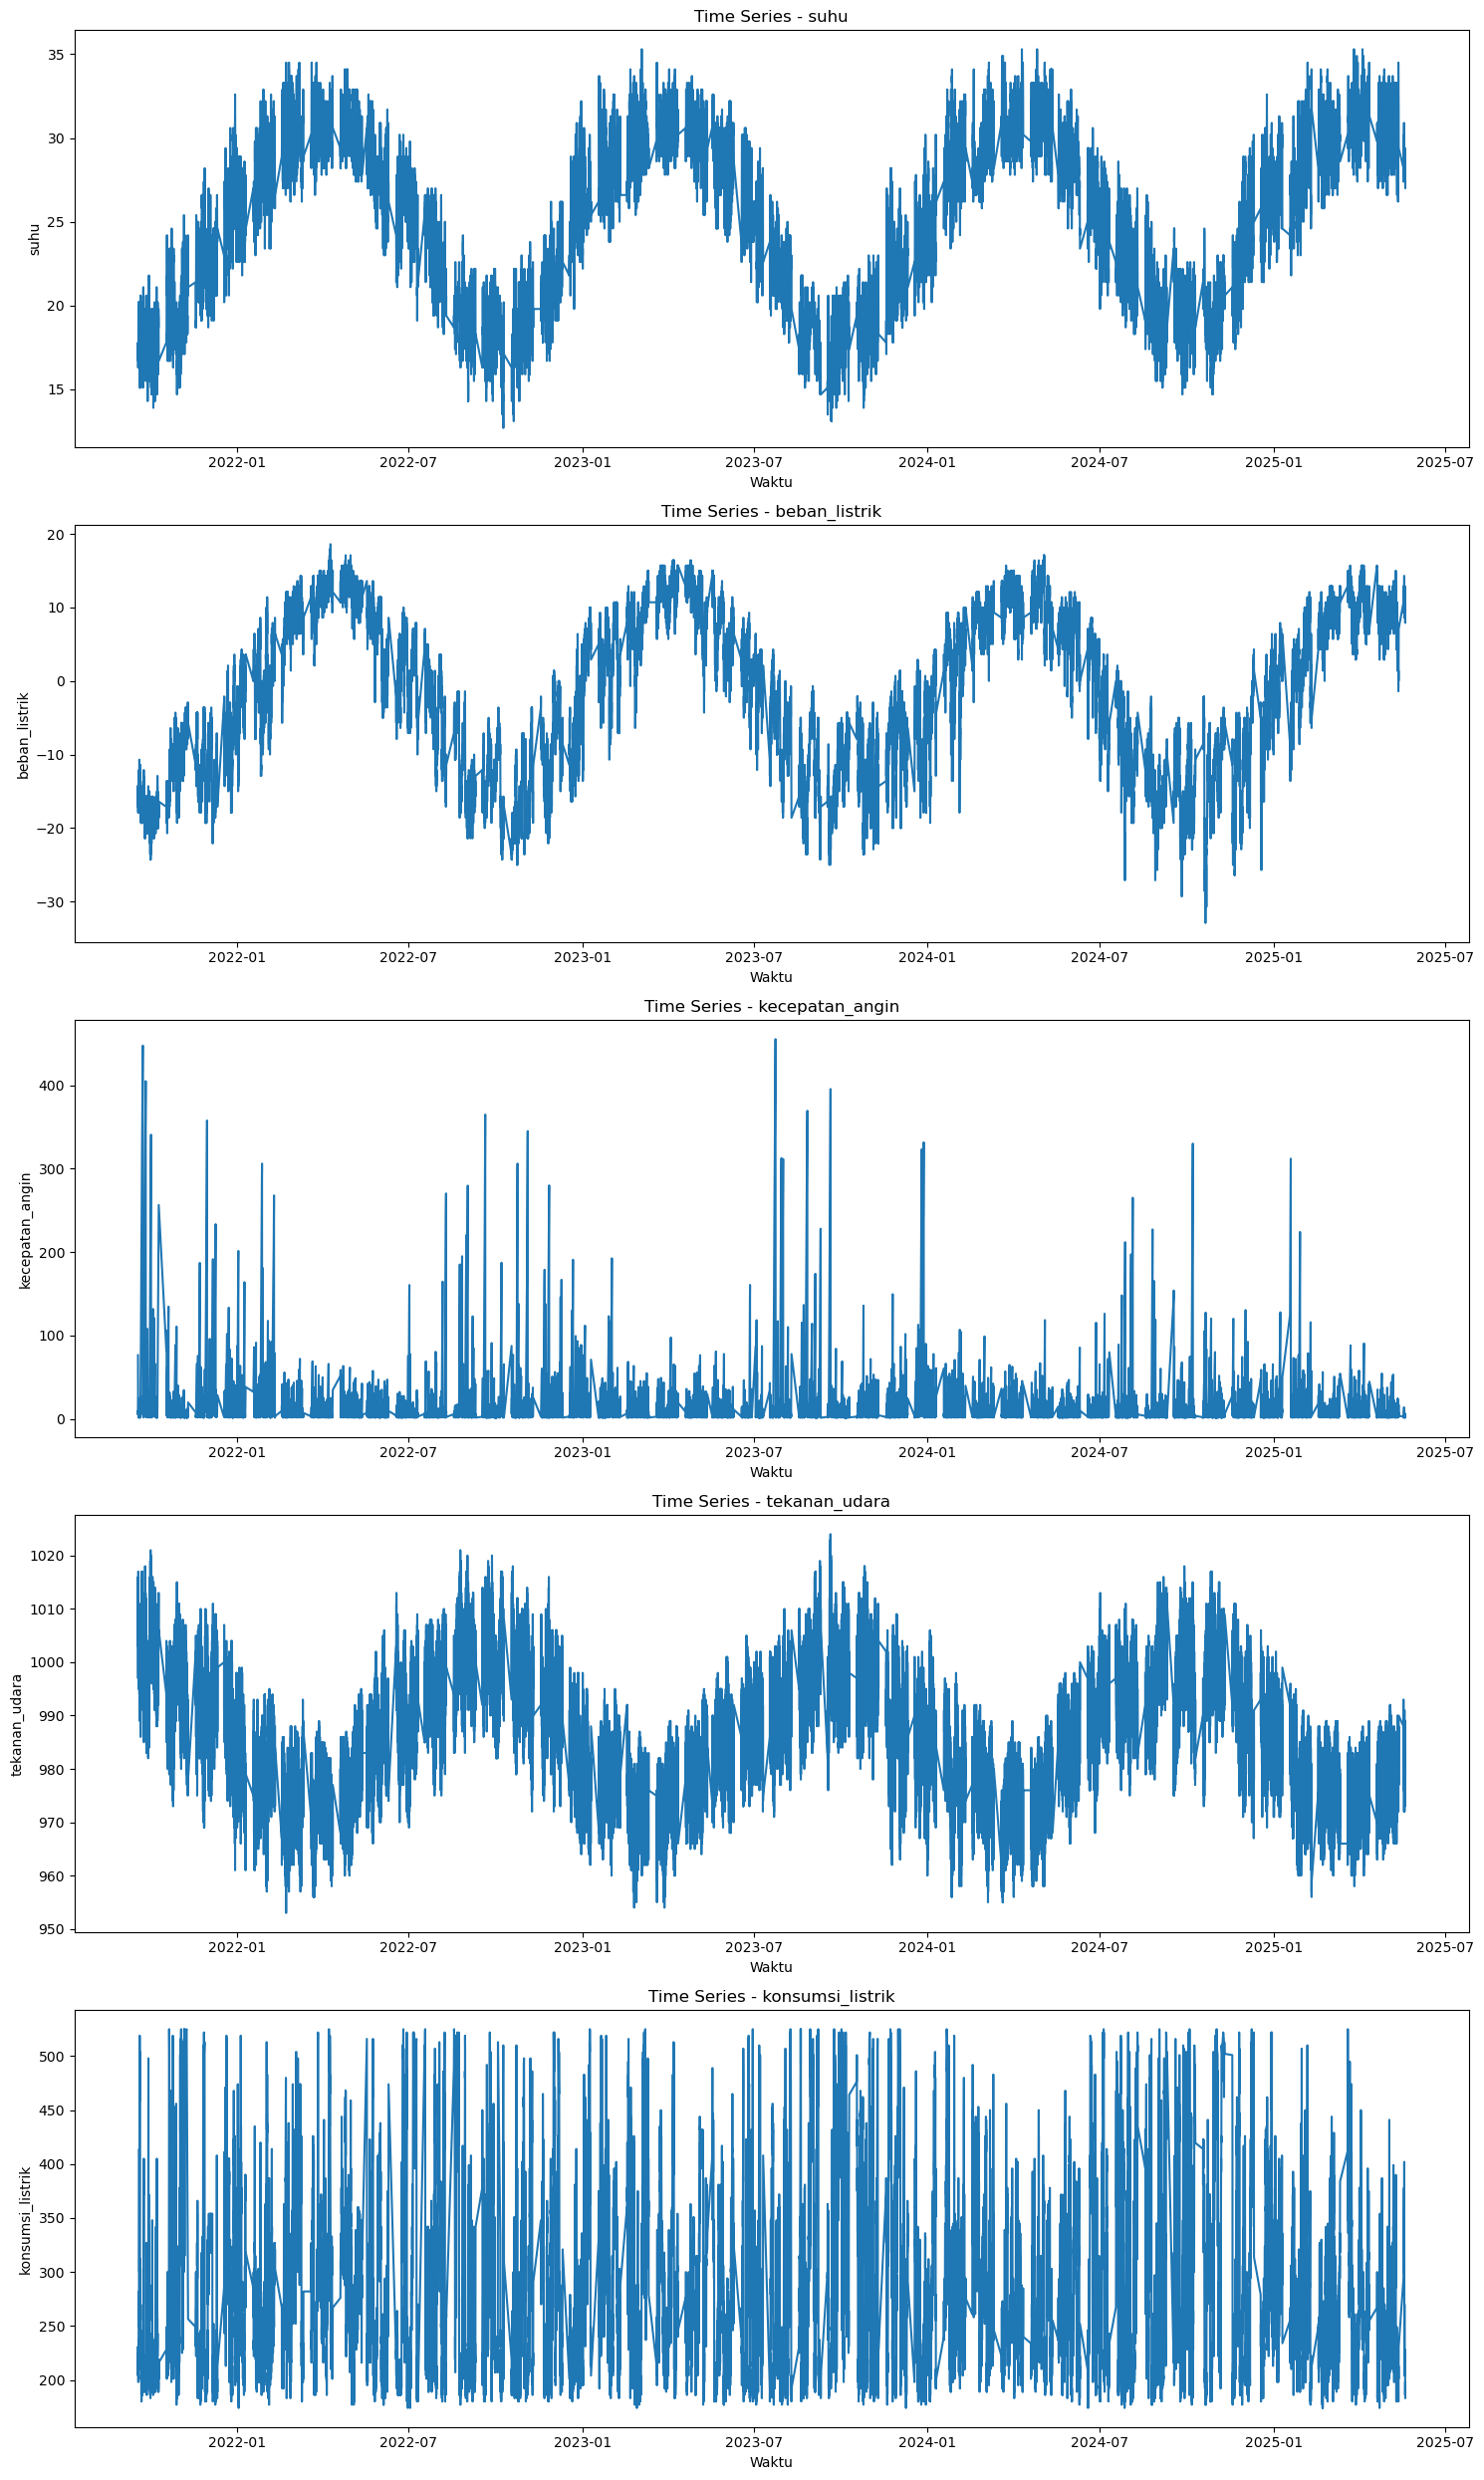

In [43]:
# a. Visualisasi Data berdasarkan Time Series
num_cols = ['suhu', 'beban_listrik', 'kecepatan_angin', 'tekanan_udara', 'konsumsi_listrik']
plt.figure(figsize=(15, 25))
for i, kolom in enumerate(num_cols, 1):
    plt.subplot(len(num_cols), 1, i)
    sns.lineplot(data=df, x='tanggal_waktu', y=kolom)
    plt.title(f'Time Series - {kolom}', fontsize=12)
    plt.xlabel('Waktu')
    plt.ylabel(kolom)
    plt.tight_layout()

plt.show()

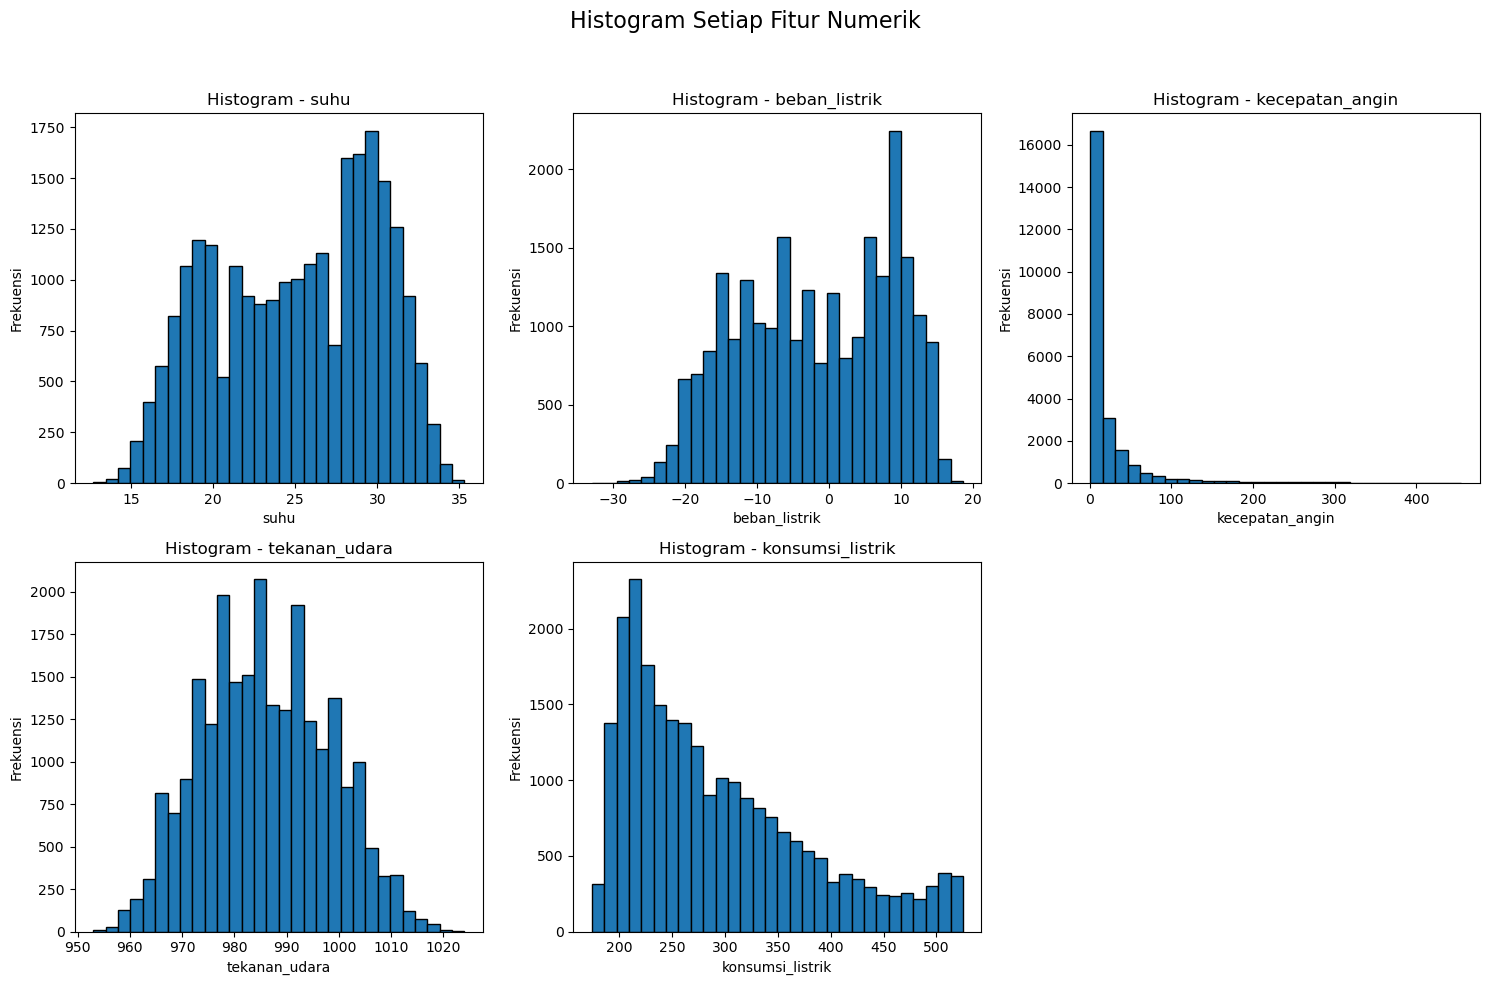

In [44]:
# b. Visualisasi Histogram
plt.figure(figsize=(15, 10))
for i, kolom in enumerate(num_cols, 1):
    plt.subplot(2, 3, i)  
    plt.hist(df[kolom], bins=30, edgecolor='black')
    plt.title(f"Histogram - {kolom}")
    plt.xlabel(kolom)
    plt.ylabel("Frekuensi")

plt.suptitle("Histogram Setiap Fitur Numerik", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95]) 
plt.show()

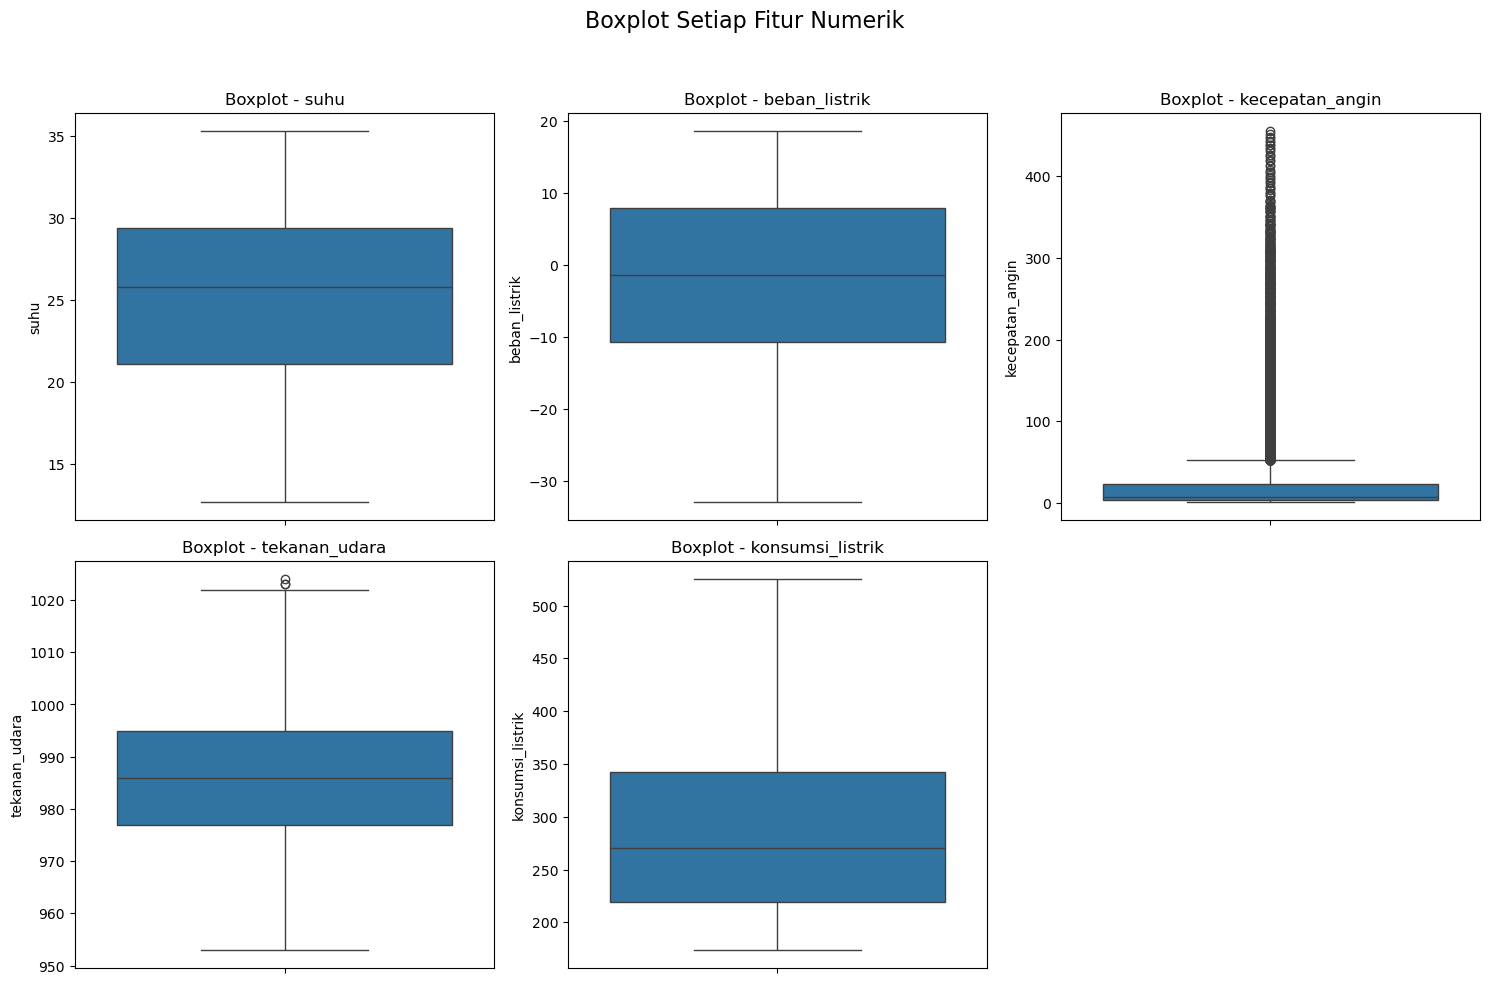

In [45]:
# c. Visualisasi Boxplot
plt.figure(figsize=(15, 10))
for i, kolom in enumerate(num_cols, 1):
    plt.subplot(2, 3, i)  # Bikin grid 2x3
    sns.boxplot(y=df[kolom])
    plt.title(f"Boxplot - {kolom}")
    plt.xlabel("")  # Hapus label x karena sudah jelas dari judul
    plt.ylabel(kolom)

plt.suptitle("Boxplot Setiap Fitur Numerik", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

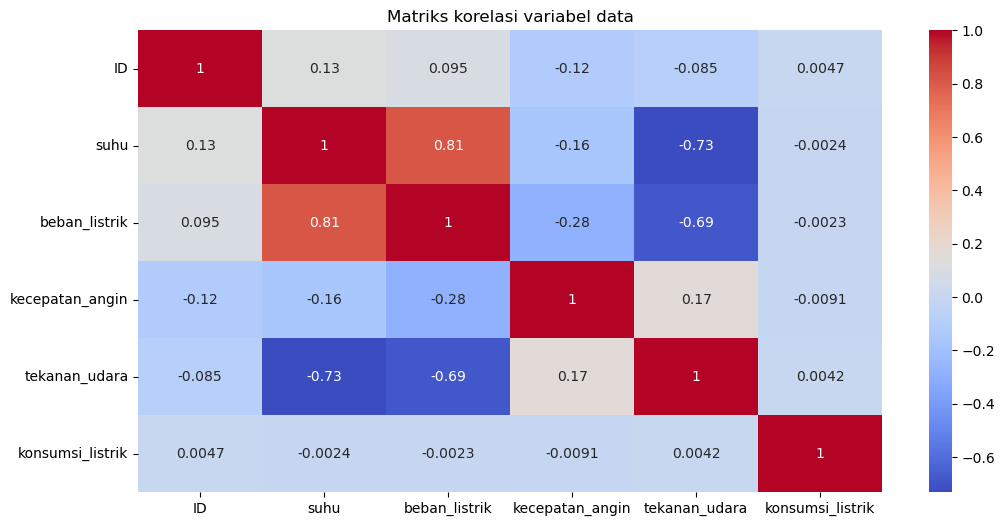

In [46]:
# d. Visualisasi Korelasi
correlation_matrix = df_train.select_dtypes(include=np.number).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Matriks korelasi variabel data")
plt.show()

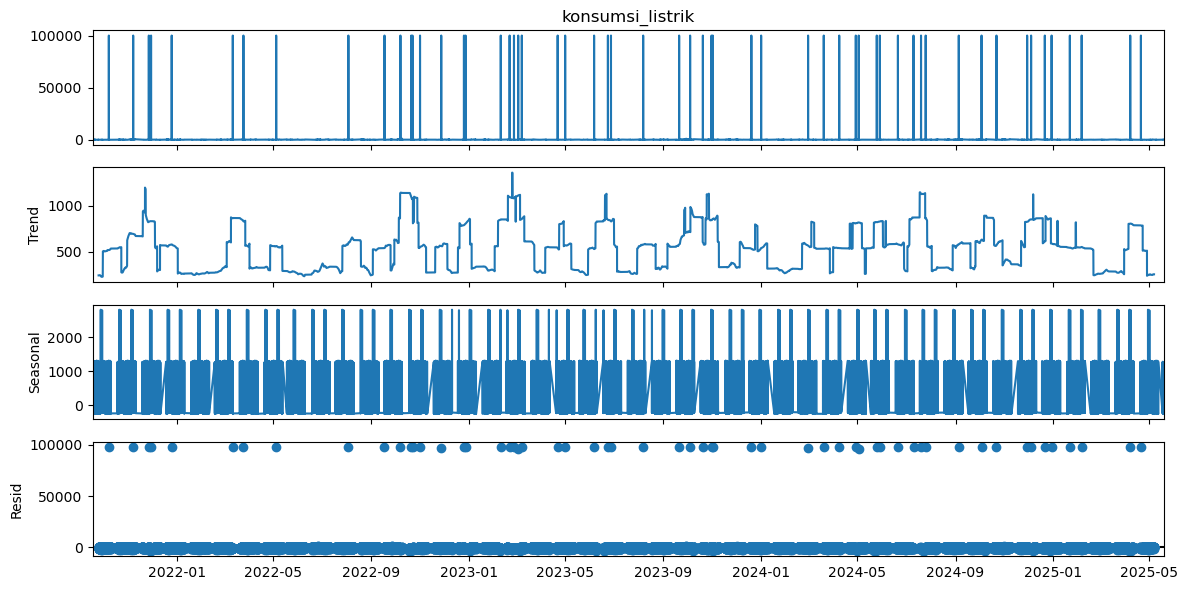

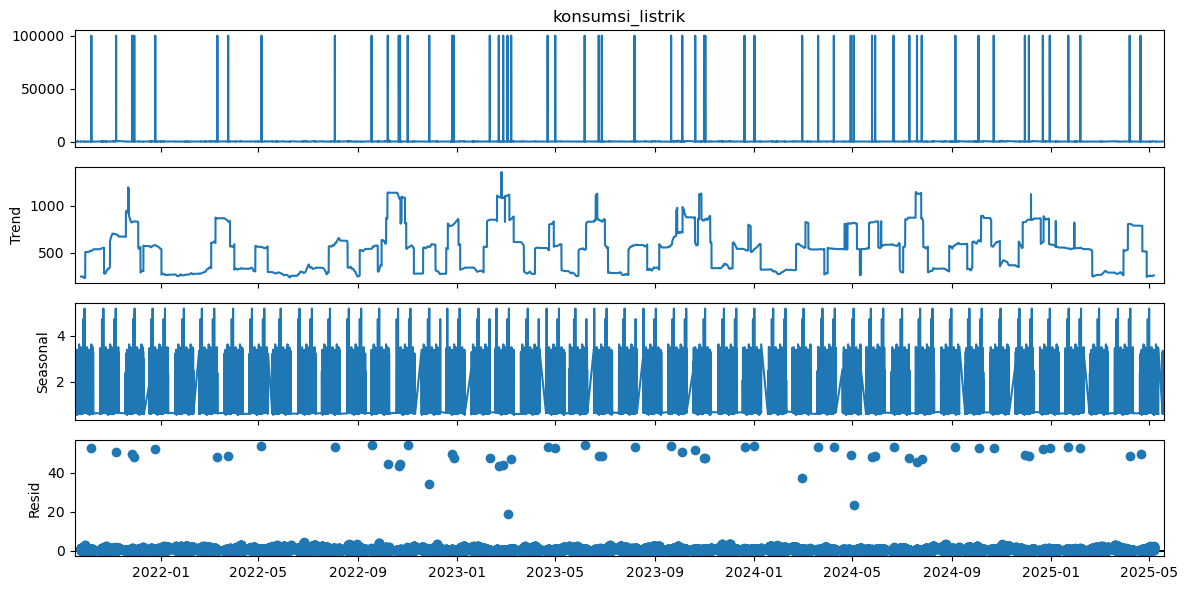

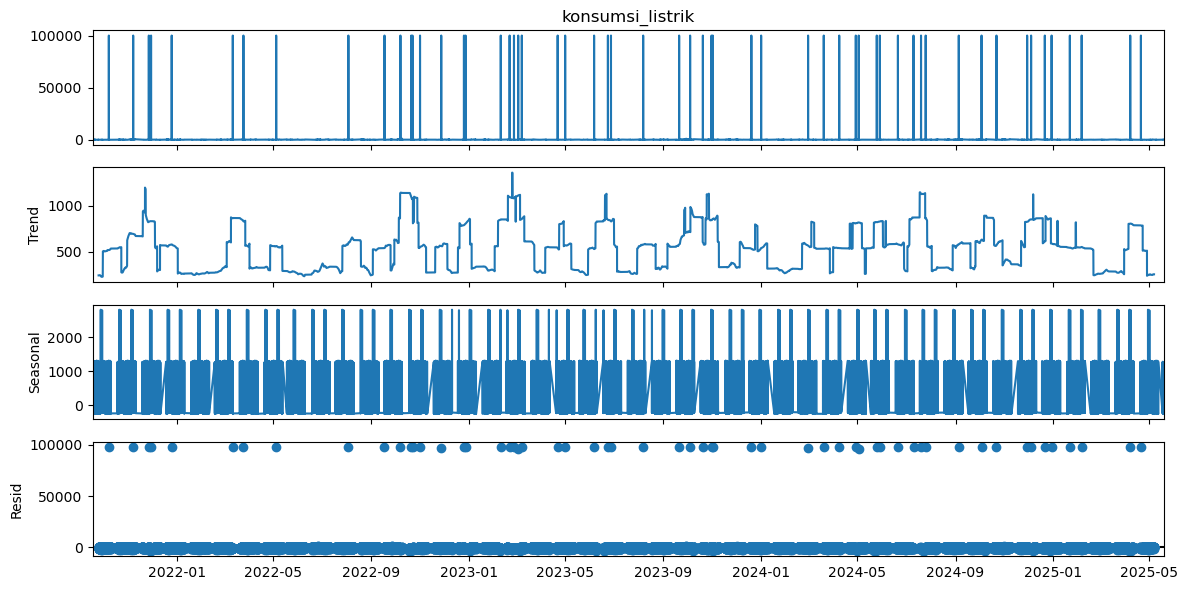

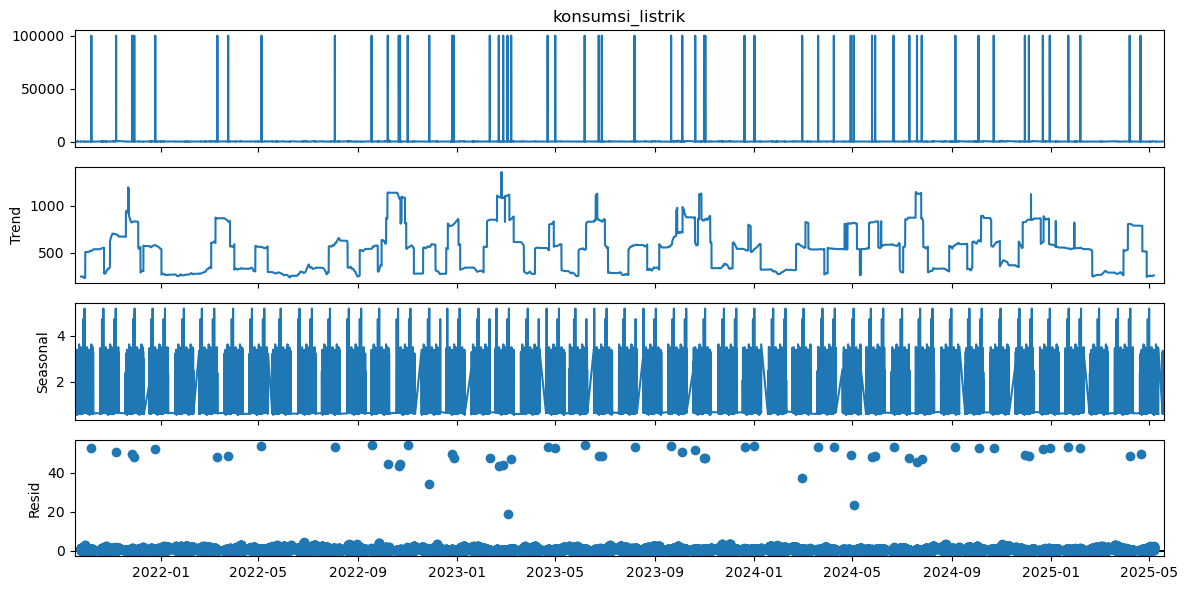

In [48]:
# e. Dekomposisi Aditive dan Multiplikatif
data_decomposition = df_train.copy()
data_decomposition['konsumsi_listrik'] = data_decomposition['konsumsi_listrik'].interpolate(limit_direction='both')

additive_decomposition = seasonal_decompose(data_decomposition['konsumsi_listrik'], model='additive', period=365)
multiplicative_decomposition = seasonal_decompose(data_decomposition['konsumsi_listrik'], model='multiplicative', period=365)

display(additive_decomposition.plot())
display(multiplicative_decomposition.plot())

In [ ]:
# 4. Fungsi Experiment
def run_experiment(df, split_ratio):
    split_idx = int(len(df) * split_ratio)
    tr, te = df.iloc[:split_idx], df.iloc[split_idx:]
    X_tr, y_tr = tr[features], tr['konsumsi_listrik']
    X_te, y_te = te[features], te['konsumsi_listrik']
    
    # ===== XGBoost =====
    xgb = XGBRegressor(n_estimators=200, max_depth=6, random_state=42)
    xgb.fit(X_tr, y_tr)
    pred_xgb = xgb.predict(X_te)
    rmse_xgb = np.sqrt(mean_squared_error(y_te, pred_xgb))
    
    # ===== Scaling untuk LSTM/GRU =====
    scaler = StandardScaler().fit(df[features])
    data_scaled = scaler.transform(df[features])
    seq_len = 24
    Xs, ys = [], []
    for i in range(seq_len, len(data_scaled)):
        Xs.append(data_scaled[i - seq_len:i])
        ys.append(df['konsumsi_listrik'].values[i])
    Xs, ys = np.array(Xs), np.array(ys)

    te_start = split_idx - seq_len
    X_trs, X_tes = Xs[:te_start], Xs[te_start:]
    y_trs, y_tes = ys[:te_start], ys[te_start:]
    
    # ===== LSTM =====
    lstm = Sequential([
        LSTM(50, input_shape=(seq_len, Xs.shape[2])),
        Dense(1)
    ])
    lstm.compile(optimizer='adam', loss='mse')
    lstm.fit(X_trs, y_trs, epochs=10, batch_size=32,
             validation_split=0.1, callbacks=[EarlyStopping(patience=3)], verbose=0)
    pred_lstm = lstm.predict(X_tes).flatten()
    rmse_lstm = np.sqrt(mean_squared_error(y_tes, pred_lstm))
    
    # ===== GRU =====
    gru = Sequential([
        GRU(50, input_shape=(seq_len, Xs.shape[2])),
        Dense(1)
    ])
    gru.compile(optimizer='adam', loss='mse')
    gru.fit(X_trs, y_trs, epochs=10, batch_size=32,
            validation_split=0.1, callbacks=[EarlyStopping(patience=3)], verbose=0)
    pred_gru = gru.predict(X_tes).flatten()
    rmse_ens = np.sqrt(mean_squared_error(y_tes, (pred_xgb[-len(pred_gru):] + pred_gru)/2))

    # Output lengkap
    return {
        'rmse_xgb': rmse_xgb,
        'rmse_lstm': rmse_lstm,
        'rmse_ensemble_gru': rmse_ens,
        'y_true': y_te[-len(pred_gru):],
        'pred_xgb': pred_xgb[-len(pred_gru):],
        'pred_lstm': pred_lstm,
        'pred_gru': pred_gru,
        'pred_ensemble_gru': (pred_xgb[-len(pred_gru):] + pred_gru) / 2
    }


In [ ]:
#5. Jalankan Eksperimen
ratios = [0.8, 0.7, 0.6]
results = []

for r in ratios:
    result = run_experiment(df, r)  
    results.append({
        'split': f'{int(r*100)}/{int((1-r)*100)}',
        'XGBoost': result['rmse_xgb'],
        'LSTM': result['rmse_lstm'],
        'Ensemble': result['rmse_ensemble_gru']
    })

res_df = pd.DataFrame(results)
res_df


e:\Coder\Anaconda\Anaconda\envs\tf-env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


152/152 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step


e:\Coder\Anaconda\Anaconda\envs\tf-env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


152/152 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step


e:\Coder\Anaconda\Anaconda\envs\tf-env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


228/228 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


e:\Coder\Anaconda\Anaconda\envs\tf-env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


228/228 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


e:\Coder\Anaconda\Anaconda\envs\tf-env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


304/304 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step


e:\Coder\Anaconda\Anaconda\envs\tf-env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


304/304 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step


,split,XGBoost,LSTM,Ensemble
0,80/19,28.373093,102.806400,57.117998
1,70/30,27.911156,113.905759,62.136461
2,60/40,27.570564,132.056532,68.907851


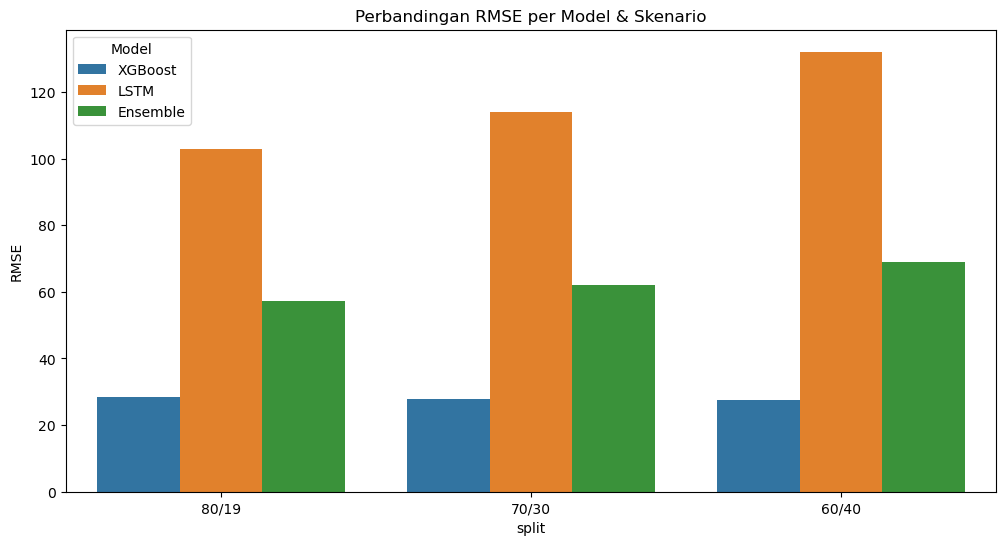

In [8]:
# 6. Visualisasi RMSE
res_melt = res_df.melt(id_vars='split', var_name='Model', value_name='RMSE')
plt.figure()
sns.barplot(data=res_melt, x='split', y='RMSE', hue='Model')
plt.title('Perbandingan RMSE per Model & Skenario')
plt.show()

e:\Coder\Anaconda\Anaconda\envs\tf-env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


304/304 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step


e:\Coder\Anaconda\Anaconda\envs\tf-env\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


304/304 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step


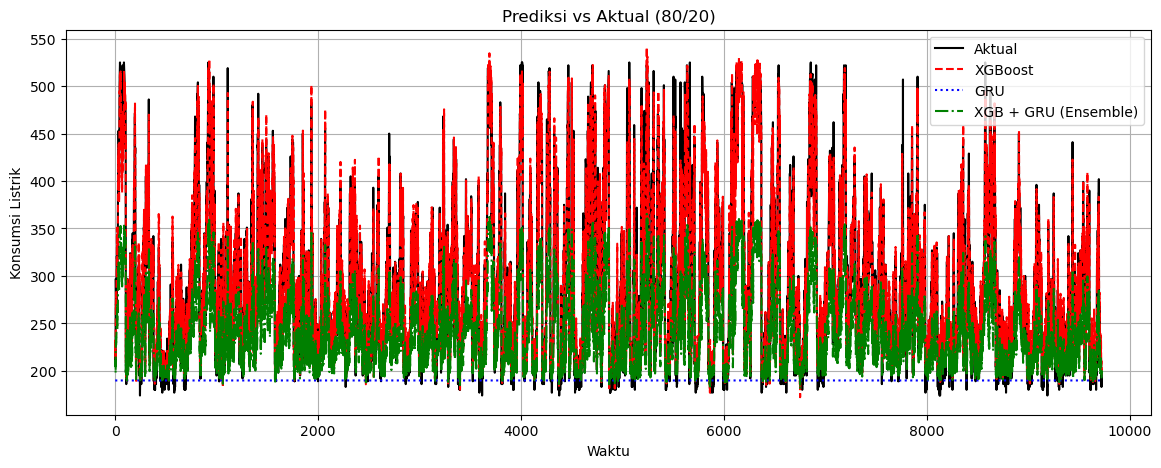

In [18]:
# 7. Prediksi vs Aktual (contoh skema 60/20)
r = 0.6
result = run_experiment(df, r)

y_act = result['y_true']
px = result['pred_xgb']
pg = result['pred_gru']
pe = result['pred_ensemble_gru']

plt.figure(figsize=(14, 5))
plt.plot(y_act.values, label='Aktual', color='k')
plt.plot(px, '--r', label='XGBoost')
plt.plot(pg, ':b', label='GRU')
plt.plot(pe, '-.g', label='XGB + GRU (Ensemble)')
plt.legend()
plt.title('Prediksi vs Aktual (80/20)')
plt.xlabel('Waktu')
plt.ylabel('Konsumsi Listrik')
plt.grid(True)
plt.show()


In [ ]:
# 8. Forecast 2160 jam (3 bulan) – Latih ulang seluruh data
# 1. Salin data pelatihan penuh 
df_full = df.copy()
X_full, y_full = df_full[features], df_full['konsumsi_listrik']

# 2. Latih XGBoost dengan seluruh data
xgb_full = XGBRegressor(n_estimators=200, max_depth=6, random_state=42)
xgb_full.fit(X_full, y_full)

# 3. Rolling forecast XGBoost 2160 jam ke depan
preds = []

for i in range(2160):
    lag1 = preds[-1] if preds else y_full.iloc[-1]
    lag24 = preds[-24] if len(preds) >= 24 else y_full.iloc[-24]

    # Ambil fitur dari data test
    feat_data = df_test.iloc[i].copy()
    feat = np.array([[feat_data['suhu'], feat_data['beban_listrik'],
                      feat_data['kecepatan_angin'], feat_data['tekanan_udara'],
                      feat_data['dampak_env_enc'], feat_data['hour'],
                      feat_data['dayofweek'], lag1, lag24]])

    # Prediksi hanya dengan XGBoost
    p_xgb = xgb_full.predict(feat)[0]
    preds.append(p_xgb)


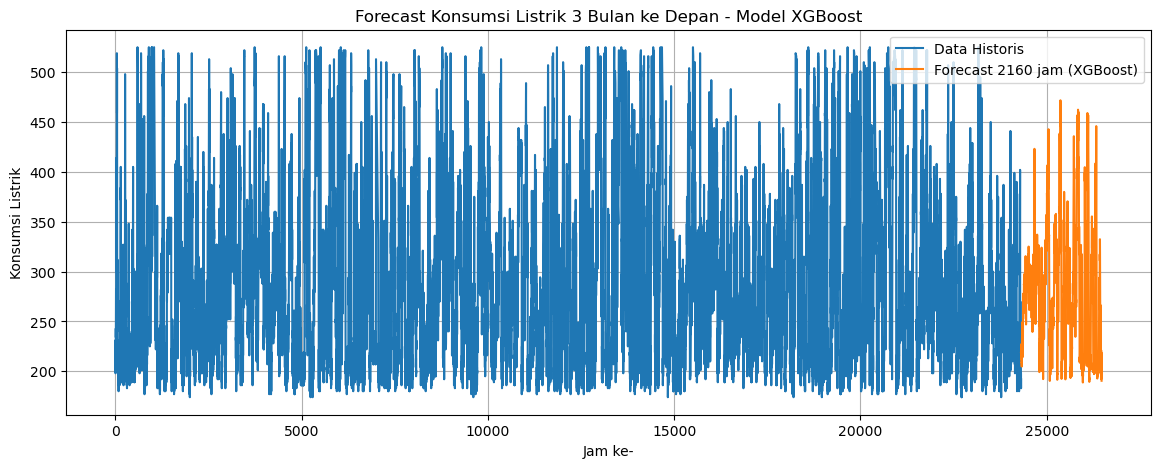

In [20]:
# 4. Plot hasil forecast
plt.figure(figsize=(14, 5))
plt.plot(range(len(df_full)), df_full['konsumsi_listrik'], label='Data Historis')
plt.plot(range(len(df_full), len(df_full) + 2160), preds, label='Forecast 2160 jam (XGBoost)')
plt.xlabel('Jam ke-')
plt.ylabel('Konsumsi Listrik')
plt.title('Forecast Konsumsi Listrik 3 Bulan ke Depan - Model XGBoost')
plt.legend()
plt.grid(True)
plt.show()
